# Recommender system
## Dataset - MovieLens 1M

In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

## Specify the checkpoint directory

In [2]:
sc.setCheckpointDir("/home/saurabh/sparkcheckpointDir/")

## Required imports

In [3]:
from pyspark.sql import SparkSession
import math
import numpy as np
from pyspark.sql import SparkSession
from pyspark.mllib.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

In [4]:
session = SparkSession.builder.appName("RecommenderSystems").getOrCreate()

# Recommender System - 1 
## Implemented from scratch

## Read data

In [5]:
ratings = sc.textFile("/home/saurabh/ml-1m/ratings.dat").map(
                        lambda line: line.split("::")).map(lambda x: (int(x[0]), (int(x[1]), float(x[2]) )))

In [6]:
ratings.take(3)

[(1, (1193, 5.0)), (1, (661, 3.0)), (1, (914, 3.0))]

## Split into train and test set

In [7]:
train, test = ratings.randomSplit([7, 3], seed=0)

## Partition data

In [8]:
ratings_partitions = train.partitionBy(2).persist()

In [9]:
ratings_partitions.take(3)

[(2, (1357, 5.0)), (2, (3068, 4.0)), (2, (1537, 4.0))]

## Create required variables

In [10]:
n_users = 6040
n_items = 3952
latent_variables = 100

global_bias = np.array([2.5])
user_latent = np.random.uniform(size = (n_users + 1, latent_variables))
user_bias = np.random.uniform(size=(n_users + 1))

item_latent = np.random.uniform(size = (n_items + 1, latent_variables))
item_bias = np.random.uniform(size = (n_items + 1))

## Core algorithm
The following code is a varient of matrix factorization for recommender systems. In addition to user and item latent variables this algorithm also uses user and item bias and global bias.

### Solving cold start problem

    -- The user bias allows to rate for new item that was not seen in the training data
    -- The item bias allows to rate for new user that was not seen in the training data
    -- Global bias allows to provide rating for both new user and new item
### Learning parameters

    -- SGD is used to learn user_bias, user_latent features, item_bias and item_latent features.
    -- Global bias is not learned. It is usually calculated as average of all the ratings.
### Regualrization
This model also performs regularization subject to the regularization parameter.

### Prediction
The prediction is globalBias + userBias + itemBias + matrixProduct

In [11]:
def localGradients(data_iterator, user_latent = user_latent, user_bias = user_bias,
                   item_latent = item_latent, item_bias = item_bias,
                   global_bias = global_bias, learning_rate = 1e-2, regularization = 1e-1):
    
    """Put default values to zeros"""
    _user_latent = np.zeros_like(user_latent)
    _item_latent = np.zeros_like(item_latent)
    _user_bias = np.zeros_like(user_bias)
    _item_bias = np.zeros_like(item_bias)
    
    for user, item_rating in data_iterator:
        item = item_rating[0]
        actual = item_rating[1]
        
        """The predicion is global_bias + user_bias + item_bias + latentFactorsDotProduct"""
        
        prediction = global_bias + user_bias[user] + item_bias[item] + np.dot(user_latent[user],
                                                                                   item_latent[item].T)
        user_latent[user] = user_latent[user] + learning_rate * \
                            (((actual - prediction) * item_latent[item]) \
                            - regularization * (user_latent[user]))
        
        item_latent[item] = item_latent[item] + learning_rate * \
                            (((actual - prediction) * user_latent[user]) \
                            - regularization * (item_latent[item]))
        
        user_bias[user] = user_bias[user] + learning_rate * \
                          ((actual - prediction) \
                          - regularization * user_bias[user])
        
        item_bias[item] = item_bias[item] + learning_rate * \
                          ((actual - prediction) \
                          - regularization * item_bias[item])
        
        """Keep weights of all non learned latent features as 0"""
        _item_bias[item] = np.array(item_bias[item])
        _item_latent[item] = np.array(item_latent[item])
        _user_bias[user] = np.array(user_bias[user])
        _user_latent[user] = np.array(user_latent[user])
        
    return (_user_latent, _item_latent, _user_bias, _item_bias)

## RMSE Calculation
Following code will calculate RMSE for the provided data

In [12]:
def RMSE(data_iterator, user_latent = user_latent, user_bias = user_bias,
        item_latent = item_latent, item_bias = item_bias,
        global_bias = global_bias):
    error = []
    
    for user, item_rating in data_iterator:
        item = item_rating[0]
        _actual = item_rating[1]
        
        """The predicion is global_bias + user_bias + item_bias + latentFactorsDotProduct"""
        
        _prediction = global_bias + user_bias[user] + item_bias[item] + np.dot(user_latent[user],
                                                                                   item_latent[item].T)
        error.append(_prediction - _actual)
    return [math.sqrt(np.mean(np.array(error) ** 2))]

## Distributed matrix factorization

    -- The above code will work in distributed settings. (Across the partitions)
    -- The average should be calculated for only non zero terms.
Following method allows to calculate average

In [13]:
def non_zero_average(x):
    sum_vector = np.zeros_like(x[0])
    cummulative = np.zeros(len(x[0]))
    for item in x:
        for index, data in enumerate(item):
            if np.sum(data) > 0:
                cummulative[index] = cummulative[index] + 1
                sum_vector[index] = sum_vector[index] + data
    for index, data in enumerate(sum_vector):
        if cummulative[index] > 0:
            sum_vector[index] = data/cummulative[index]
    return sum_vector

In [14]:
def average(data, index, n_partitions):
    array = []
    while index < n_partitions * 4:
        array.append(data[index])
        index = index + 4
    return non_zero_average(array)

## Reduce method is not used
The following code does not use a reduce method. This is because the output of the map partitions is an array and not a tuple. 

In [15]:
trainRMSEList = []
testRMSEList = []
partition_count =  ratings_partitions.getNumPartitions()
for i in range(0, 10):
    
    
    """Check performance"""
    rmse = ratings_partitions.mapPartitions(lambda x:RMSE(x, user_latent=user_latent,
                                                          user_bias=user_bias,
                                                          item_latent=item_latent,
                                                          item_bias=item_bias,
                                                         global_bias=global_bias))
    rmse = np.average(rmse.coalesce(1).collect())
    print("Train RMSE-"+str(rmse))
    trainRMSEList.append(rmse)
    
    rmse = test.mapPartitions(lambda x:RMSE(x, user_latent=user_latent,
                                            user_bias=user_bias,
                                            item_latent=item_latent, item_bias=item_bias,
                                            global_bias=global_bias))
    rmse = np.average(rmse.coalesce(1).collect())
    print("Test RMSE-"+str(rmse))
    testRMSEList.append(rmse)
    
    """Train model"""
    tmp = ratings_partitions.mapPartitions(lambda x:localGradients(x, user_latent=user_latent,
                                                                     user_bias=user_bias,
                                                                     item_latent=item_latent,
                                                                     item_bias=item_bias,
                                                                     global_bias=global_bias))
    tmp = tmp.coalesce(1).collect()
    user_latent = average(tmp, 0, partition_count)
    item_latent = average(tmp, 1, partition_count)
    user_bias = average(tmp, 2, partition_count)
    item_bias = average(tmp, 3, partition_count)
    
    print("\n\n")

Train RMSE-25.058494210066556
Test RMSE-25.061564781800932



Train RMSE-1.3912778700616217
Test RMSE-1.4836147226254353



Train RMSE-0.9718266521290175
Test RMSE-1.1243123750950648



Train RMSE-0.9052402275926952
Test RMSE-1.0567820449881378



Train RMSE-0.8827609682704174
Test RMSE-1.0248377990720927



Train RMSE-0.8733300245326387
Test RMSE-1.0052995680618988



Train RMSE-0.8693399681715661
Test RMSE-0.9918792889263015



Train RMSE-0.867650549118595
Test RMSE-0.981681846194268



Train RMSE-0.8673571371066514
Test RMSE-0.9737957586843251



Train RMSE-0.8671835985965081
Test RMSE-0.9673039346124579





In [16]:
rmse = ratings_partitions.mapPartitions(lambda x:RMSE(x, user_latent=user_latent,
                                                      user_bias=user_bias,
                                                      item_latent=item_latent, item_bias=item_bias,
                                                       global_bias=global_bias))
rmse = np.average(rmse.coalesce(1).collect())
print("Train RMSE-"+str(rmse))
trainRMSEList.append(rmse)
    
rmse = test.mapPartitions(lambda x:RMSE(x, user_latent=user_latent,
                                        user_bias=user_bias,
                                        item_latent=item_latent, item_bias=item_bias,
                                        global_bias=global_bias))

rmse = np.average(rmse.coalesce(1).collect())
print("Test RMSE-"+str(rmse))
testRMSEList.append(rmse)


Train RMSE-0.8671977557957844
Test RMSE-0.9619186176332075


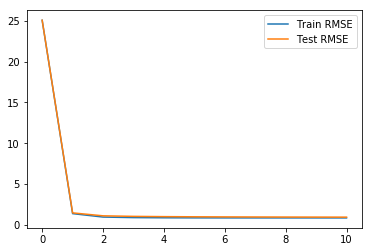

In [17]:
plt.plot(trainRMSEList, label = "Train RMSE")
plt.plot(testRMSEList, label = "Test RMSE")
plt.legend()
plt.show()

The best performance on train set is 0.86 and test set is 0.96. We can say that the algorithm slightly overfits to the training dataset.

# Recommender System - 2 
## Implemented using MLLib
### Read data

In [18]:
ratings = sc.textFile("/home/saurabh/ml-1m/ratings.dat").map(
                        lambda token: token.split("::")).map(lambda token: (
                                                            int(token[0]), int(token[1]), float(token[2])))
movies = sc.textFile("/home/saurabh/ml-1m/movies.dat").map(
                        lambda token: token.split("::")).map(lambda token: (token[0], token[1]))

ratings.take(3)

[(1, 1193, 5.0), (1, 661, 3.0), (1, 914, 3.0)]

### Split in train and test set

In [19]:
train, test = ratings.randomSplit([7, 3], seed=0)

### Transform RDD

In [20]:
def transformRDD(rdd):
    return rdd.map(lambda r: ((r[0], r[1]), r[2]))

### Calculate RMSE

In [21]:
def RMSE_MLLib(actual, predictions):
    joined_rdd = transformRDD(actual).join(predictions)
    error = math.sqrt(joined_rdd.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    return error

### Grid search for hyper parameter search

In [22]:
"""here rank is hyper parameter"""
rankList = [5, 25, 35, 45, 100]
leastError = None
bestRank = None


_train, _validation = train.randomSplit([7, 3], seed=0)
for rank in rankList:
    """lambda_ is used for regularization"""
    model = ALS.train(_train, rank, iterations=20, lambda_=0.1)
    _validation_transformed = _validation.map(lambda p: (p[0], p[1]))
    prediction = transformRDD(model.predictAll(_validation_transformed))
    error = RMSE_MLLib(_validation, prediction)
    print("Rank-"+str(rank)+" error "+str(error))
    if leastError is None or leastError > error:
        leastError = error
        bestRank = rank

model = ALS.train(train, bestRank, iterations=20, lambda_=0.1)

_test = test.map(lambda p: (p[0], p[1]))
prediction = transformRDD(model.predictAll(_test))
error = RMSE_MLLib(test, prediction)
print("Error on test set is "+str(error))

Rank-5 error 0.8790564334285227
Rank-25 error 0.8753892226100661
Rank-35 error 0.8751212570490433
Rank-45 error 0.8756921670140858
Rank-100 error 0.8755746255382981
Error on test set is 0.8625036830611713


## Summary

    -- Comparing the two implementations, spark's default implementation is much more optimized. 
    -- It also generates better results. Test set accuracy of 0.96 vs 0.86
    -- When compared to existing approaches the accuracy is 0.857 for biased matrix factorization method which is very close to the baseline